In [ ]:
%run util.ipynb
%run feature_engineering2.ipynb

In [26]:
numeric_predictor = ['사상자수', '사망자수', '중상자수', '경상자수', '부상신고자수']
categorical_predictor = ['주야', '요일', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류', '당사자종별_2당_대분류']
test_columns = np.array(numeric_predictor + categorical_predictor)

In [27]:
df = pd.read_csv("../data/original_kor.csv", encoding='euc-kr')

In [28]:
train, highway, jaywalk, elder, child, bike, school, danger, nmf = read_dataset("../data/original_kor.csv", 'euc-kr')
train_eng = change(train, highway, jaywalk, elder, child, bike, school, danger, nmf )

works


In [29]:
original_test = pd.read_csv("../data/test_kor.csv")
original_test_cold = original_test.columns

In [30]:
val, highway, jaywalk, elder, child, bike, school, danger, nmf = read_dataset("../data/test_kor.csv", None)
test_eng = change(val, highway, jaywalk, elder, child, bike, school, danger, nmf )

works


In [31]:
col_order = train_eng.columns

# Start from here!

## binning1

In [32]:
test_eng['type'] = 'test'
train_eng['type'] = 'train'
df_binned = binning1(pd.concat([test_eng,train_eng]))
col_names = df_binned.columns

In [33]:
df_binned = df_binned.reset_index(drop=True)

In [34]:
df_binned = df_binned.fillna('-999')

In [35]:
df_binned = df_binned.astype(str)

In [36]:
def get_cat_mapping_set(df):
    cat_mapping_set = {}
    col_names = df.columns
    for col_name in col_names:
        le = preprocessing.LabelEncoder()
        result = le.fit(df[col_name])    
        cat_mapping_set[col_name] = le
    
    return cat_mapping_set

def encode_df(df, cat_mapping_set):
    tmp_dic_lst = []
    col_names = df.columns
    for col_name in col_names:
        tmp_dic_lst.append(cat_mapping_set[col_name].transform(df[col_name]))
    tmp_dic_lst = np.array(tmp_dic_lst)    
    combined_df_encoded = pd.DataFrame(np.matrix(tmp_dic_lst.T), columns=col_names)
    return combined_df_encoded

def decode_df(df, cat_mapping_set):
    tmp_dic_lst = []
    col_names = df.columns
    for col_name in col_names:
        tmp_dic_lst.append(cat_mapping_set[col_name].inverse_transform(df[col_name]))
    tmp_dic_lst = np.array(tmp_dic_lst)  
    combined_df_decoded = pd.DataFrame(np.matrix(tmp_dic_lst.T), columns=col_names) 
    return combined_df_decoded

In [37]:
cat_mapping_set = get_cat_mapping_set(df_binned)

In [38]:
df_encoded = encode_df(df_binned, cat_mapping_set)

In [39]:

test = df_encoded.loc[df_encoded.type == 0]
train = df_encoded.loc[df_encoded.type == 1]

train.drop(columns=['type'], inplace=True)
test.drop(columns=['type'], inplace=True)

In [40]:
train_dum = train[col_order]
test_dum = test[col_order]

## Fit Bayesian Network

In [41]:
auto_chow_net = BayesianNetwork.from_samples(train_dum.as_matrix(), algorithm='chow-liu', n_jobs=-1)

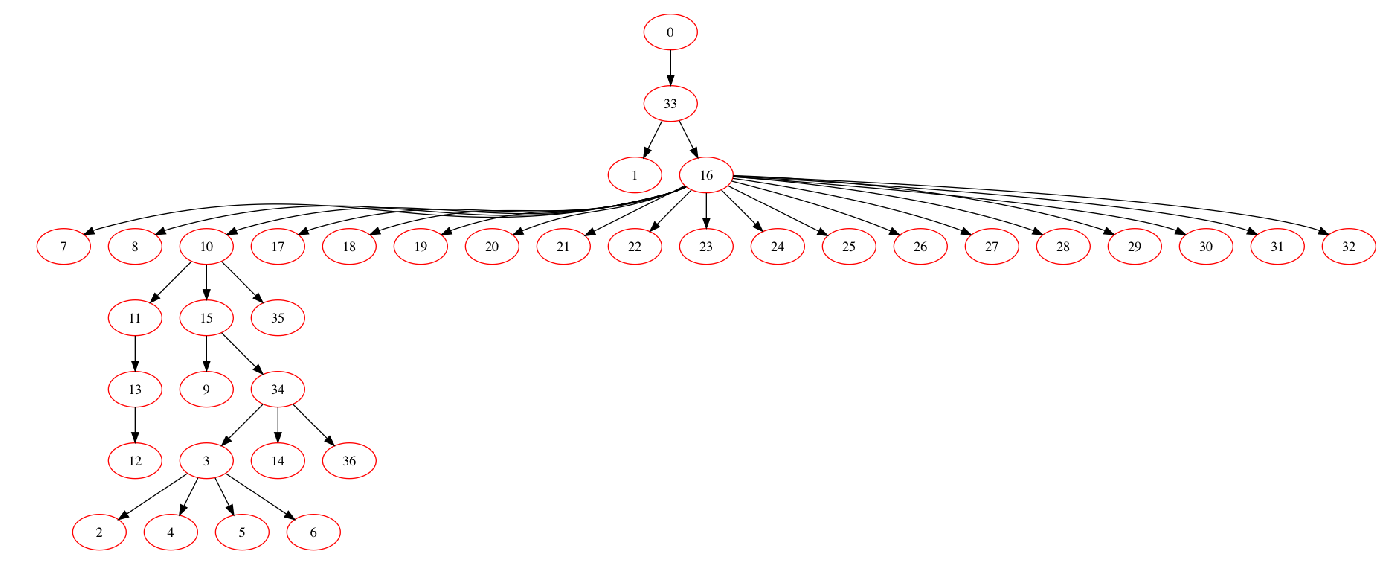

In [43]:
plt.figure(figsize=(100, 10))
auto_chow_net.plot()

## Prepare test dataset

In [44]:
test_dum[test_dum == 0] = None

In [45]:
test_mat = test_dum.as_matrix()

## Predict with the model

In [47]:
result = auto_chow_net.predict(test_mat, n_jobs=-1)

In [48]:
result_df = pd.DataFrame(result, columns=col_order)

In [49]:
result_df['type'] = 0
result_df = result_df.astype(int)

In [50]:
decoded_df = decode_df(result_df, cat_mapping_set)

In [87]:
decoded_df[['발생지시도','발생지시군구', '발생지']]

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,...,학교건수,요일_사고유형_NMF1,요일_사고유형_NMF2,요일_사고유형_NMF3,발생지시군구_위험도,발생지시도x요일x주야_위험도,차량조합_위험도,사고유형_위험도,위험도평균,type
0,야간,금,1.0,1.0,0.0,0.0,0.0,경기,화성시,차대차,...,1.0,3.0,5.0,2.0,2.0,2.0,5.0,2.0,4.0,test
1,야간,금,1.0,1.0,0.0,0.0,0.0,전남,영암군,차대사람,...,0.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,test
2,야간,월,1.0,1.0,0.0,0.0,0.0,전남,곡성군,차량단독,...,0.0,1.0,1.0,1.0,5.0,1.0,1.0,2.0,3.0,test
3,야간,일,2.0,5.0,1.0,1.0,0.0,대구,달성군,차대차,...,0.0,2.0,3.0,2.0,2.0,2.0,5.0,2.0,4.0,test
4,주간,목,1.0,1.0,0.0,0.0,0.0,전남,고흥군,차대차,...,3.0,2.0,2.0,1.0,1.0,2.0,3.0,5.0,3.0,test
5,주간,목,2.0,2.0,1.0,0.0,0.0,경북,영천시,차대차,...,0.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,3.0,test
6,야간,수,1.0,1.0,0.0,0.0,0.0,충남,아산시,차대차,...,2.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0,5.0,test
7,주간,월,1.0,5.0,3.0,5.0,0.0,충남,서천군,차대차,...,0.0,2.0,2.0,1.0,2.0,1.0,3.0,4.0,3.0,test
8,주간,일,1.0,13.0,6.0,5.0,5.0,강원,평창군,차대차,...,0.0,1.0,2.0,1.0,4.0,4.0,5.0,2.0,5.0,test
9,주간,수,1.0,1.0,0.0,0.0,0.0,충북,음성군,차대사람,...,0.0,3.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,test


In [86]:
decoded_df.발생지

0      경기화성시
1      전남영암군
2      전남곡성군
3      대구달성군
4      전남고흥군
5      경북영천시
6      충남아산시
7      충남서천군
8      강원평창군
9      충북음성군
10     경남의령군
11      대전중구
12      대구북구
13     울산울주군
14     경기수원시
15     전북완주군
16     경남거창군
17     충남천안시
18     충남서산시
19     전남곡성군
20     경기의왕시
21     경기평택시
22     전남광양시
23     경기평택시
24     충남당진시
25     전북익산시
26     경남하동군
27    서울동대문구
28     경기평택시
29     충남홍성군
30      인천중구
31     전북전주시
32      대구서구
33     광주광산구
34     서울서초구
35     충남당진시
36     경기화성시
37     경북경주시
38     경기용인시
39     경북경주시
40     서울동작구
41     경기가평군
42     경기부천시
43      대전동구
44     충남보령시
45     전북고창군
46     서울은평구
47     서울성동구
48     서울서초구
49     경북의성군
Name: 발생지, dtype: object

In [51]:

train_set = decode_df(train_dum, cat_mapping_set)

In [52]:
decoded_df = decode_df(result_df, cat_mapping_set)

In [53]:
y_train = train_set[numeric_predictor]

In [54]:
y_train = y_train.drop(columns=['사상자수'])

In [55]:
# y_train

In [56]:
X_train = train_set.drop(columns=numeric_predictor)
X_test = decoded_df.drop(columns=numeric_predictor)

In [57]:
X_train['type'] = 'train'
X_test['type'] = 'test'

In [58]:
X_total = pd.concat([X_train, X_test])

In [59]:
X_total_dummy = pd.get_dummies(X_total)

In [60]:
X_train_dummy = X_total_dummy.loc[X_total_dummy.type_train == 1]

In [61]:
X_test_dummy = X_total_dummy.loc[X_total_dummy.type_train == 0]

In [62]:

X_train_dummy = X_train_dummy.drop(columns=['type_test', 'type_train'])
X_test_dummy = X_test_dummy.drop(columns=['type_test', 'type_train'])

In [63]:
clf_best = RandomForestRegressor(
    n_estimators=1000,
    bootstrap=False,
    max_depth=20,
    max_features=10,
    min_samples_leaf=1,
    min_samples_split=10,
    n_jobs=-1
)

## Fit Random Forest model

In [64]:
clf_best.fit(X_train_dummy, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

## Predict with RF

In [65]:
pred_clf_best = clf_best.predict(X_test_dummy)

In [66]:
pred_last = pd.DataFrame(pred_clf_best, columns=y_train.columns)

In [67]:
result_mat = pd.concat([pred_last.apply(sum, axis=1), pred_last], axis=1)

In [68]:
result_mat.columns = numeric_predictor

In [79]:
category_done_df = decoded_df[original_test_cold]

In [80]:
category_done_df_X = category_done_df.drop(columns=numeric_predictor)

In [81]:
ultimate_df = pd.concat([category_done_df_X, result_mat], axis=1)

In [82]:
ultimate_df = ultimate_df[original_test_cold]

In [84]:
ultimate_df.head()

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
0,야간,금,1.071673,3.000780,0.754537,0.992418,0.182153,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
1,야간,금,1.017190,1.193003,0.111061,0.059588,0.005164,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자
2,야간,월,1.035432,1.334290,0.200916,0.088400,0.009542,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음
3,야간,일,1.091752,2.800046,0.847121,0.715463,0.145710,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
4,주간,목,1.090531,2.298753,0.633949,0.540102,0.034171,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차


In [193]:
ultimate_df.head()

,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
0,야간,금,1.065013,2.901382,0.726480,0.951599,0.158290,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
1,야간,금,1.013914,1.181545,0.102520,0.060302,0.004809,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자
2,야간,월,1.035529,1.340366,0.201254,0.093175,0.010408,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음
3,야간,일,1.087347,2.829554,0.872509,0.727814,0.141884,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
4,주간,목,1.089334,2.294202,0.630290,0.541379,0.033200,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차


In [195]:
result_df = pd.read_csv('../data/result_kor.csv', encoding='cp949')

In [197]:
# result_df

In [198]:

test_df = ultimate_df

output = []
for k, v in result_df.iterrows():
    r = v['행'] - 2
    c = ord(v['열']) - 65
    result_df.loc[k, '값'] = test_df.iloc[r, c]

In [203]:
result_df.to_csv('../data/result.csv', index=False, encoding='euc-kr')

In [204]:
ultimate_df.to_csv('../data/ultimate_test.csv', index=False, encoding='euc-kr')